# Projet

In [ ]:
pip install pyspark

Note: you may need to restart the kernel to use updated packages.


### Le point d'entrée dans toutes les fonctionnalités de Spark est la classe SparkSession:

In [ ]:
from pyspark.sql import SparkSession

In [ ]:
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [ ]:
#Spark est une SparkSession existante
df = spark.read.csv("assurance.csv",header=True)
# Afficher le contenu du DataFrame
df.show()

+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+
| id|Gender|Age|Driving_License|Region_Code|Previously_Insured|Vehicle_Age|Vehicle_Damage|Annual_Premium|Policy_Sales_Channel|Vintage|Response|
+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+
|  1|  Male| 44|              1|       28.0|                 0|  > 2 Years|           Yes|       40454.0|                26.0|    217|       1|
|  2|  Male| 76|              1|        3.0|                 0|   1-2 Year|            No|       33536.0|                26.0|    183|       0|
|  3|  Male| 47|              1|       28.0|                 0|  > 2 Years|           Yes|       38294.0|                26.0|     27|       1|
|  4|  Male| 21|              1|       11.0|                 1|   < 1 Year|            No|       28619.0|               152.0|    203|  

### Analyse générale

In [ ]:
# Print the schema in a tree format
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Driving_License: string (nullable = true)
 |-- Region_Code: string (nullable = true)
 |-- Previously_Insured: string (nullable = true)
 |-- Vehicle_Age: string (nullable = true)
 |-- Vehicle_Damage: string (nullable = true)
 |-- Annual_Premium: string (nullable = true)
 |-- Policy_Sales_Channel: string (nullable = true)
 |-- Vintage: string (nullable = true)
 |-- Response: string (nullable = true)



In [ ]:
#create spark cable (link df to our table)
df.createOrReplaceTempView("assurance")

### Nombre de femmes assurés

In [ ]:
spark.sql("SELECT count(Gender) FROM  assurance WHERE Gender='Female'").show()

+-------------+
|count(Gender)|
+-------------+
|       175020|
+-------------+



### Nombre des femmes ayant un véhicule âgé de plus de 2 ans

In [ ]:
spark.sql("""SELECT count(Gender)
FROM assurance
WHERE Gender = 'Female' AND Vehicle_Age = '> 2 Years'
""").show()

+-------------+
|count(Gender)|
+-------------+
|         5707|
+-------------+



### La moyenne des Annual_Premium pour les hommes ayant des véhicules endommagés 

In [ ]:
spark.sql("""SELECT avg(Annual_Premium)
FROM assurance
WHERE Gender = 'Male' AND Vehicle_Damage = 'Yes'
""").show()

+-------------------+
|avg(Annual_Premium)|
+-------------------+
| 30734.777069216307|
+-------------------+



### Creation un dataFrame contenant les colonnes  (id , Gender,Age , Vehicle_Age , Annual_Premium , Response)

In [ ]:
data=spark.sql("SELECT id, Gender, Age, Vehicle_Age,Vehicle_Damage, Annual_Premium, Response From assurance")

In [ ]:
data.show()

+---+------+---+-----------+--------------+--------------+--------+
| id|Gender|Age|Vehicle_Age|Vehicle_Damage|Annual_Premium|Response|
+---+------+---+-----------+--------------+--------------+--------+
|  1|  Male| 44|  > 2 Years|           Yes|       40454.0|       1|
|  2|  Male| 76|   1-2 Year|            No|       33536.0|       0|
|  3|  Male| 47|  > 2 Years|           Yes|       38294.0|       1|
|  4|  Male| 21|   < 1 Year|            No|       28619.0|       0|
|  5|Female| 29|   < 1 Year|            No|       27496.0|       0|
|  6|Female| 24|   < 1 Year|           Yes|        2630.0|       0|
|  7|  Male| 23|   < 1 Year|           Yes|       23367.0|       0|
|  8|Female| 56|   1-2 Year|           Yes|       32031.0|       1|
|  9|Female| 24|   < 1 Year|            No|       27619.0|       0|
| 10|Female| 32|   < 1 Year|            No|       28771.0|       0|
| 11|Female| 47|   1-2 Year|           Yes|       47576.0|       1|
| 12|Female| 24|   < 1 Year|            No|     

###  Enregistrer le nouveau dataframe au format json

In [ ]:
#premierement transformer la data en pandas DataFrame et puis l'enregistrer en json
pandas_df = data.toPandas()   
pandas_df.to_json("C:/Users/NK/Desktop/BIgData2/assurance.json")

# Prétraitement

### Cration d'une fonction udf permettant de convertir les valeurs de la colonne Vehicle_Damage en 1 et 0

In [ ]:
from pyspark.sql.functions import when
from pyspark.sql.types import IntegerType, DoubleType

In [ ]:
new_data=data.withColumn("Vehicle_Damage", when(df.Vehicle_Damage=='Yes', str(1)).otherwise(str(0)))

### Creation d'une fonction udf pour encoder la colonne Vehicle_Age en valeurs numérique

In [ ]:
#>2 Years=>3 / 1-2 Years =>2 / <1 Year => 1
new_data=new_data.withColumn("Vehicle_Age", when(df.Vehicle_Age=='> 2 Years', 3).when(df.Vehicle_Age=='1-2 Year', 2)
                             .otherwise(1))


### Creation d'une fonction udf pour encoder la colonne Gender en valeurs numérique

In [ ]:
#Male=>1 / Female =>0
new_data=new_data.withColumn("Gender", when(df.Gender=='Male', 1).otherwise(0))
  

In [ ]:
#transformer tous les colonnes en numerique
new_data= new_data.withColumn("id", new_data["id"].cast(IntegerType()))
new_data= new_data.withColumn("Age",new_data["Age"].cast(IntegerType()))
new_data= new_data.withColumn("Vehicle_Damage", new_data["Vehicle_Damage"].cast(IntegerType()))
new_data= new_data.withColumn("Annual_Premium", new_data["Annual_Premium"].cast(DoubleType()))
new_data= new_data.withColumn("Response", new_data["Response"].cast(IntegerType()))

In [ ]:
new_data.show()

+---+------+---+-----------+--------------+--------------+--------+
| id|Gender|Age|Vehicle_Age|Vehicle_Damage|Annual_Premium|Response|
+---+------+---+-----------+--------------+--------------+--------+
|  1|     1| 44|          3|             1|       40454.0|       1|
|  2|     1| 76|          2|             0|       33536.0|       0|
|  3|     1| 47|          3|             1|       38294.0|       1|
|  4|     1| 21|          1|             0|       28619.0|       0|
|  5|     0| 29|          1|             0|       27496.0|       0|
|  6|     0| 24|          1|             1|        2630.0|       0|
|  7|     1| 23|          1|             1|       23367.0|       0|
|  8|     0| 56|          2|             1|       32031.0|       1|
|  9|     0| 24|          1|             0|       27619.0|       0|
| 10|     0| 32|          1|             0|       28771.0|       0|
| 11|     0| 47|          2|             1|       47576.0|       1|
| 12|     0| 24|          1|             0|     

In [ ]:
new_data.printSchema()

root
 |-- id: integer (nullable = true)
 |-- Gender: integer (nullable = false)
 |-- Age: integer (nullable = true)
 |-- Vehicle_Age: integer (nullable = false)
 |-- Vehicle_Damage: integer (nullable = true)
 |-- Annual_Premium: double (nullable = true)
 |-- Response: integer (nullable = true)



# Classification

In [ ]:
# Notre classses ne sont pas balancé, ce qui peut affecter la performance du modèle
new_data.groupBy('Response').count().show()

+--------+------+
|Response| count|
+--------+------+
|       1| 46710|
|       0|334399|
+--------+------+



In [ ]:
#Verifier est ce qu'il y a des valeurs manquantes
from pyspark.sql.functions import isnan,when,count,col
df3.select([count(when(isnan(c),c)).alias(c) for c in df3.columns]).toPandas().head()

,id,Gender,Age,Vehicle_Age,Vehicle_Damage,Annual_Premium,Response
0,0,0,0,0,0,0,0


# Regression Logistique

In [ ]:
#importer les librairies qu'on a besoin
from pyspark.ml.feature import VectorAssembler 
from pyspark.ml.feature import StandardScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator,BinaryClassificationEvaluator 
from pyspark.sql.functions import col,count,isnan,when
from pyspark.ml.classification import NaiveBayes
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import LinearSVC

In [ ]:
cols=new_data.columns
cols.remove("Response")
assembler=VectorAssembler(inputCols=cols,outputCol="features")

In [ ]:
data=assembler.transform(new_data)

In [ ]:
assembled_data=data.select("features","Response")
assembled_data.show(truncate=False)

+-------------------------------+--------+
|features                       |Response|
+-------------------------------+--------+
|[1.0,1.0,44.0,3.0,1.0,40454.0] |1       |
|[2.0,1.0,76.0,2.0,0.0,33536.0] |0       |
|[3.0,1.0,47.0,3.0,1.0,38294.0] |1       |
|[4.0,1.0,21.0,1.0,0.0,28619.0] |0       |
|[5.0,0.0,29.0,1.0,0.0,27496.0] |0       |
|[6.0,0.0,24.0,1.0,1.0,2630.0]  |0       |
|[7.0,1.0,23.0,1.0,1.0,23367.0] |0       |
|[8.0,0.0,56.0,2.0,1.0,32031.0] |1       |
|[9.0,0.0,24.0,1.0,0.0,27619.0] |0       |
|[10.0,0.0,32.0,1.0,0.0,28771.0]|0       |
|[11.0,0.0,47.0,2.0,1.0,47576.0]|1       |
|[12.0,0.0,24.0,1.0,0.0,48699.0]|0       |
|[13.0,0.0,41.0,2.0,0.0,31409.0]|0       |
|[14.0,1.0,76.0,2.0,1.0,36770.0]|0       |
|[15.0,1.0,71.0,2.0,0.0,46818.0]|0       |
|[16.0,1.0,37.0,2.0,1.0,2630.0] |1       |
|[17.0,0.0,25.0,1.0,1.0,26218.0]|0       |
|[18.0,0.0,25.0,1.0,0.0,46622.0]|0       |
|[19.0,1.0,42.0,2.0,1.0,33667.0]|0       |
|[20.0,0.0,60.0,2.0,1.0,32363.0]|1       |
+----------

In [ ]:
train, test = assembled_data.randomSplit([0.7, 0.3], seed = 101)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 266679
Test Dataset Count: 114430


In [ ]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'Response', maxIter=10)
lrModel = lr.fit(train)

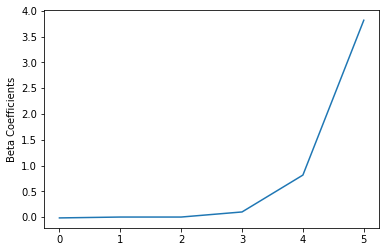

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

In [ ]:
predictions = lrModel.transform(test)
predictions.select( 'Response', 'rawPrediction', 'prediction', 'probability').show(10)

+--------+--------------------+----------+--------------------+
|Response|       rawPrediction|prediction|         probability|
+--------+--------------------+----------+--------------------+
|       0|[5.51673139071782...|       0.0|[0.99599712449218...|
|       0|[1.70117733968426...|       0.0|[0.84568843969869...|
|       0|[5.24376564608918...|       0.0|[0.99474740001367...|
|       1|[1.00714407330278...|       0.0|[0.73246086797093...|
|       0|[0.98160906174986...|       0.0|[0.72742737266476...|
|       0|[1.34321280366951...|       0.0|[0.79301778934897...|
|       0|[5.25360385121595...|       0.0|[0.99479855532826...|
|       0|[0.98637716388765...|       0.0|[0.72837175078188...|
|       0|[1.55773177719013...|       0.0|[0.82602763680699...|
|       0|[4.79681243601420...|       0.0|[0.99181158200879...|
+--------+--------------------+----------+--------------------+
only showing top 10 rows



In [ ]:
predictions.select('prediction').distinct().show()

+----------+
|prediction|
+----------+
|       0.0|
|       1.0|
+----------+



In [ ]:
predictiolAnsLabels=predictions.select("Response","prediction").rdd
evaluator=MulticlassClassificationEvaluator(labelCol="Response",predictionCol="prediction",metricName="accuracy")
accuaracy_RL=evaluator.evaluate(predictions)
print("Accuracy",accuaracy_RL)

Accuracy 0.878388534475225


# Naïve Bayes

In [ ]:
naive_Bayes=NaiveBayes(featuresCol="features",labelCol="Response",smoothing=1.0)
model=naive_Bayes.fit(train)
prediction_test=model.transform(test)
prediction_test.show()

+--------------------+--------+--------------------+--------------------+----------+
|            features|Response|       rawPrediction|         probability|prediction|
+--------------------+--------+--------------------+--------------------+----------+
|[5.0,0.0,29.0,1.0...|       0|[-54822.687211346...|           [0.0,1.0]|       1.0|
|[6.0,0.0,24.0,1.0...|       0|[-5452.5011667905...|[1.65097585468999...|       1.0|
|[15.0,1.0,71.0,2....|       0|[-93552.368268747...|           [0.0,1.0]|       1.0|
|[16.0,1.0,37.0,2....|       1|[-5591.4148724942...|[2.40438345908264...|       1.0|
|[19.0,1.0,42.0,2....|       0|[-67220.075342856...|           [0.0,1.0]|       1.0|
|[21.0,1.0,65.0,2....|       0|[-82335.186541109...|           [0.0,1.0]|       1.0|
|[23.0,1.0,23.0,1....|       0|[-90080.007908578...|           [0.0,1.0]|       1.0|
|[24.0,1.0,44.0,2....|       0|[-83479.158715483...|           [0.0,1.0]|       1.0|
|[34.0,0.0,24.0,1....|       0|[-85816.434969853...|           [0

In [ ]:
prediction_test.select('prediction').distinct().show()

+----------+
|prediction|
+----------+
|       0.0|
|       1.0|
+----------+



In [ ]:
predictiolAnsLabels=prediction_test.select("Response","prediction").rdd
evaluator=MulticlassClassificationEvaluator(labelCol="Response",predictionCol="prediction",metricName="accuracy")
accuaracy_NB=evaluator.evaluate(prediction_test)
print("Accuracy",accuaracy_NB)

Accuracy 0.514567858079175


# SVM

In [ ]:
# Define your classifier
lsvc = LinearSVC( featuresCol='features', labelCol='Response',predictionCol='prediction',maxIter=10, regParam=0.1)
# Fit the model
lsvcModel = lsvc.fit(assembled_data)
# Print the coefficients and intercept for linearsSVC
coefficients = lsvcModel.coefficients
intercept = lsvcModel.intercept
print("Some coefficients: " + str(coefficients[250:300]))
print("Intercept: " + str(intercept))

Some coefficients: []
Intercept: -1.422223046245257


In [ ]:
# Compute predictions for test data
predictions = lsvcModel.transform(test)

# Show the computed predictions and compare with the original labels
predictions.select("features", "Response", "prediction").show(10)

# Define the evaluator method with the corresponding metric and compute the classification error on test data
evaluator=MulticlassClassificationEvaluator(labelCol="Response",predictionCol="prediction",metricName="accuracy")
accuracy = evaluator.evaluate(predictions) 



+--------------------+--------+----------+
|            features|Response|prediction|
+--------------------+--------+----------+
|[5.0,0.0,29.0,1.0...|       0|       0.0|
|[6.0,0.0,24.0,1.0...|       0|       0.0|
|[15.0,1.0,71.0,2....|       0|       0.0|
|[16.0,1.0,37.0,2....|       1|       0.0|
|[19.0,1.0,42.0,2....|       0|       0.0|
|[21.0,1.0,65.0,2....|       0|       0.0|
|[23.0,1.0,23.0,1....|       0|       0.0|
|[24.0,1.0,44.0,2....|       0|       0.0|
|[34.0,0.0,24.0,1....|       0|       0.0|
|[36.0,1.0,41.0,2....|       0|       0.0|
+--------------------+--------+----------+
only showing top 10 rows



In [ ]:
# Show the accuracy
print("Test accuracy = %g" % (accuracy))

Test accuracy = 0.878651
